In [2]:
!pip install colorama

In [3]:
import random
import pprint
import io
import pandas as pd 
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style
from matplotlib import pyplot as plt 

In [ ]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [ ]:
class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape
    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barriers in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]

      #Rewards of each state
      reward = 1.0 if is_done(s) else -1
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[np.random.randint(0,100)]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

In [ ]:
# Learning Q values 
def learnQ (gamma, alpha, epsilon, epochs):
  env =  GridworldEnv()
  # Initialize q table 
  qTable = np.zeros((100,4))
  rewards = []
  for i in range(epochs):
    iter = 0 
    done = False
    totalReward = 0 
    env.reset()
    state = env.s
    reward = 0 
    #  Ending episode when reached the final state and moved in it 
    while reward!= 1 :
      # Selecting action values in epsilon-greedy algorithm 
      if np.random.uniform(0, 1) < epsilon : 
        action = env.action_space.sample()
      else : 
        action = np.argmax(qTable[state, :])
    # Getting state and reward from the world 
      statePrime, reward, done, info = env.step(action)
      totalReward += reward
      Q = qTable[state, action]
      maxQ = np.max(qTable[statePrime])
      QPrime = (1 - alpha) * Q + alpha * (reward + gamma * maxQ)
      qTable[state, action] = QPrime
    # Returning to the first place when encountering 
    # Cyan blocks 
      if(state in [13,62,41]) :
        env.reset()
        state = env.s
      else : 
      # Updating state values 
        state = statePrime 
        iter += 1
      if iter > 2000 :
      # When not having reward for each movement in the map 
      #   the agent may wander so long and doesnt improve the values 
      #   we will terminate it's movement in this condition 
        break
    # After some epochs the q values learned are good enough for convergence 
    # so we diminish the value of epsilon for less exploring and more exploiting 
    if i%100 and epsilon >0.01 : 
      epsilon = epsilon * 0.9 
    rewards.append(totalReward)
  return rewards, qTable

[[10.          9.73        9.99271     9.9993439 ]
 [ 7.8813      7.2895217   7.20862211  9.        ]
 [ 7.28995695  6.5078559   6.0118443   8.1       ]
 [ 6.54505677  5.85688491 -3.25993157  7.29      ]
 [ 0.          5.17092093  4.16649744  6.561     ]
 [ 4.8361131   4.78192296  4.77798143  5.9049    ]
 [ 4.77134639  3.83569535  4.30373067  5.31441   ]
 [ 0.          0.          0.          4.782969  ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.441       0.          0.          0.        ]
 [ 8.09393684  0.          0.          0.        ]
 [ 7.230951   -5.733       0.          0.        ]
 [-9.9757     -9.9757     -9.9757     -3.50864357]
 [ 5.7454677   0.          0.          0.        ]
 [ 5.31440998  0.          0.          0.        ]
 [ 4.782969    3.52543131  3.86479057  4.76312069]
 [ 4.30467208  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.  

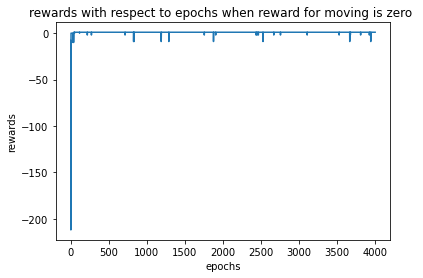

In [ ]:
# Running without -1 reward for moving in the field 
gamma = 0.9 
epsilon = 0.5
alpha = 0.7 
epochs = 4000 
[rewards, qs] = learnQ(gamma, alpha, epsilon, epochs)
plt.plot(range(epochs), rewards)
plt.title('rewards with respect to epochs when reward for moving is zero ')
plt.xlabel('epochs')
plt.ylabel('rewards')
print(qs)
print(rewards[len(rewards)-1])

In [ ]:
# Moving in the field with respect to the q values learned earlier 
def playWithRespectToQ (qTable) : 
  env =  GridworldEnv()
  iter = 0 
  totalReward = 0 
  env.reset()
  state = env.s
  env._render()
  rewards = []
  moves = []
  reward = 0 
  while reward!= 1:
    action = np.argmax(qTable[state, :])
    statePrime, reward, done, info = env.step(action)
    if(state in [13,62,41]) :
      env.reset()
      state = env.s
    else :
      state = statePrime
      iter += 1
    if (iter > 100) : 
      break
    totalReward += reward
    rewards.append(reward)
    moves.append(statePrime)
    env._render()
    print(action)
  print('total reward is ', totalReward)
  print('moves are', moves)
  print('rewards are ', rewards)

In [ ]:
playWithRespectToQ(qs)

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    웃   .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    웃   .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .

[[ 9.33273434e+00  1.00000000e+01  8.97162314e+00  9.90768850e+00]
 [ 5.94291907e+00  4.45794774e+00  3.96924941e+00  8.00000000e+00]
 [-1.31508366e+00 -5.07479005e-01 -1.66244568e+00  6.19913849e+00]
 [-2.10082160e+00 -2.33726630e+00 -6.20234057e+00  4.47349805e+00]
 [-2.66748319e+00 -2.70583021e+00 -2.90810774e+00  2.52448967e+00]
 [-3.33943885e+00 -3.29036088e+00 -3.29179311e+00 -2.79023294e+00]
 [-3.58626814e+00 -3.44064697e+00 -3.43166183e+00 -3.55699307e+00]
 [-3.38636072e+00 -3.42238536e+00 -3.54054985e+00 -3.44501998e+00]
 [-3.38225103e+00 -3.44579565e+00 -3.51814586e+00 -3.45737130e+00]
 [-3.47974955e+00 -3.43920360e+00 -3.56952764e+00 -3.44686783e+00]
 [ 7.99934234e+00 -1.03074346e+00 -3.00000000e-01 -3.00000000e-01]
 [ 6.20000000e+00  3.04135302e+00  2.40163671e+00  6.02944072e+00]
 [-1.54714978e+00 -3.22430846e+00 -1.64593044e+00  4.57961099e+00]
 [-6.95028164e+00 -1.03987729e+01 -1.00717352e+01 -1.00061122e+01]
 [ 3.52330684e-01 -3.44290184e+00 -3.25287282e+00 -6.52532980e

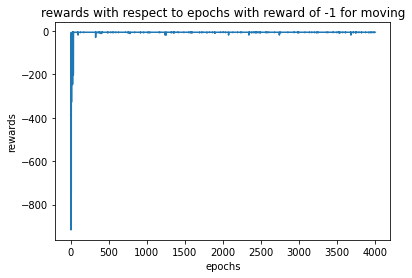

In [ ]:
# Running with -1 reward for moving in the field 
gamma = 0.9 
epsilon = 0.7
alpha = 0.3 
epochs = 4000 
[rewards, qsWithReward] = learnQ(gamma, alpha, epsilon, epochs)
plt.plot(range(epochs), rewards)
plt.title('rewards with respect to epochs with reward of -1 for moving')
plt.xlabel('epochs')
plt.ylabel('rewards')
print(qsWithReward)
print(rewards[len(rewards)-1])

In [ ]:
playWithRespectToQ(qsWithReward)

Output hidden; open in https://colab.research.google.com to view.